## Randomized Feature Based Least Square Classifiers

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
mat_contents = scipy.io.loadmat('mnist', appendmat=True)

In [2]:
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show

def normalize_data(data):
    return data / 255.0

In [3]:
def identity(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)
    
def sin(x):
    return np.sin(x)
    
"""
train_x: (60000, 785) -> (60000, 1000)
"""
def feature_map(train_x, L=1000, function=identity, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    normalize_data(train_x)
    train_x = np.column_stack((train_x, np.ones(len(train_x)))) # shape (60000, 785)

    # A random matrix with Gaussian distribution
    W = np.random.normal(0, 1, (train_x.shape[1], L)) # W has shape (785, 1000)

    product = np.dot(train_x, W)
    
    product = function(product) # shape (60000, 1000)
    
    return product

In [8]:
"""
train_x: (60000, 784)
train_y: (1, 60000)
a, b: integers to train on
"""
def ovo_get_weights(train_x, train_y, a, b):
    # Preprocess train data
    
    # train_x = np.column_stack((train_x, np.ones(len(train_x))))                                 # train_x: (60000, 785)
    # train_y = np.where(train_y == a, 1, np.where(train_y == b, -1, 0)).astype('int8')       # train_y (60000, 1)
    train_y = train_y.T
    mask = np.where((train_y == a) | (train_y == b))[0]
    masked_x = train_x[mask]
    masked_y = train_y[mask]

    masked_x = np.column_stack((masked_x, np.ones(len(masked_x))))
    masked_y = np.where(masked_y == a, 1, -1).astype('int8')
    
    # Calculate weights
    pinv = np.linalg.pinv(masked_x)                                 # pinv: (785, n) 
    return np.dot(pinv, masked_y)                                # weights: (785, 1)

In [9]:
"""
weights: (785, 1)
test_x: (60000, 784)
test_y: (1, 60000)
a, b: integers to train on
"""
def ovo_get_preds(weights, test_x, test_y, a, b):
    # Preprocess test data
    test_y = test_y.T                                              # test_y: (1, 10000) to (10000, 1)
    normalize_data(test_x)
    test_x = np.column_stack((test_x, np.ones(len(test_x))))       # test_x: (10000, 785)

    # Calculate predictions
    ovo_preds = np.dot(test_x, weights)                                # preds: (10000, 1)
    ovo_preds = ovo_preds[:, 0]                                            
    ovo_preds = np.where(ovo_preds >= 0, 1, -1).astype('int8')             

    return ovo_preds

In [10]:
"""
train_x: (60000, 784)
train_y: (1, 60000)
test_x: (10000, 1)
test_y: (1, 60000)
"""
def ovo_classifier(train_x, train_y, test_x, test_y):
    
    votes = np.zeros((len(test_x), 10), dtype=int)
    
    pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]

    for (i, j) in tqdm(pairs):
        ovo_preds = ovo_get_preds(
                ovo_get_weights(train_x, train_y, i, j),
                test_x, 
                test_y, 
                i, j)

        # For every pair, increment the vote of a certain class in votes
        for k in range(len(ovo_preds)):
            if ovo_preds[k] == 1:
                votes[k][i] += 1
            elif ovo_preds[k] == -1:
                votes[k][j] += 1
    
    return np.argmax(votes, axis=1)

In [11]:
"""
preds: (10000, 1)
test_y: (1, 10000)
"""
def eval_ovo_classifier(ovo_preds, test_y, title='Confusion Matrix'):
    # Plot a confusion matrix
    conf_matrix = [[0 for _ in range(10)] for _ in range(10)]    
    for i in range(len(test_y[0])):
        conf_matrix[test_y[0][i]][ovo_preds[i]] += 1
    conf_matrix = np.array(conf_matrix)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plot_confusion_matrix(conf_matrix, class_names, title)

    # Find the error rate
    correct = 0
    for i in range(10):
        for j in range(10):
            if i == j:
                correct += conf_matrix[i][j]
    acc = 100 * correct/10000
    print("Accuracy: {:.2f}%".format(acc, 2))
    print("Error rate: {:.2f}%".format(100 - acc, 2))

In [12]:
train_x = np.array(mat_contents['trainX'])
train_y = np.array(mat_contents['trainY'])
test_x = np.array(mat_contents['testX'])
test_y = np.array(mat_contents['testY'])

In [13]:
seed_train_x = feature_map(train_x, L=1000, function=identity, seed=1)
seed_test_x = feature_map(test_x, L=1000, function=identity, seed=1)

no_seed_train_x = feature_map(train_x, L=1000, function=identity)
no_seed_test_x = feature_map(test_x, L=1000, function=identity)

relu_train_x = feature_map(train_x, L=1000, function=relu, seed=1)
relu_test_x = feature_map(test_x, L=1000, function=relu, seed=1)

sig_train_x = feature_map(train_x, L=1000, function=sigmoid, seed=1)
sig_test_x = feature_map(test_x, L=1000, function=sigmoid, seed=1)

sig_train_x = feature_map(train_x, L=1000, function=sigmoid, seed=1)
sig_test_x = feature_map(test_x, L=1000, function=sigmoid, seed=1)

sin_train_x = feature_map(train_x, L=1000, function=sin, seed=1)
sin_test_x = feature_map(test_x, L=1000, function=sin, seed=1)

/var/folders/sk/m_1xv2y17xx96_8k07vtlgz80000gn/T/ipykernel_89650/3559522382.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [14]:
seed_preds = ovo_classifier(seed_train_x, train_y, seed_test_x, test_y)

100%|███████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:19<00:00,  3.11s/it]


Accuracy: 92.98%
Error rate: 7.02%


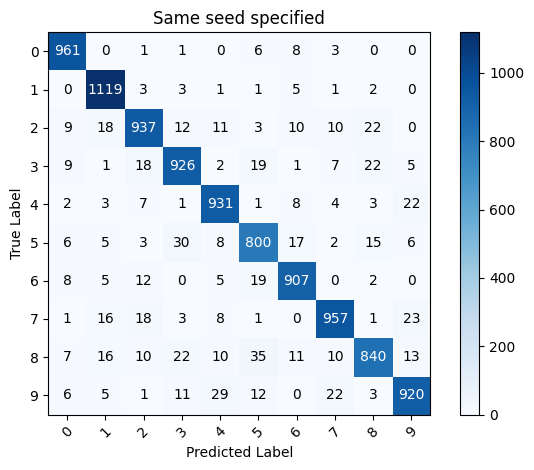

In [16]:
eval_ovo_classifier(seed_preds, test_y, 'Same seed specified')

In [17]:
no_seed_preds = ovo_classifier(no_seed_train_x, train_y, no_seed_test_x, test_y)

100%|███████████████████████████████████████████████████████████████████████████████████████| 45/45 [03:46<00:00,  5.02s/it]


Accuracy: 7.96%
Error rate: 92.04%


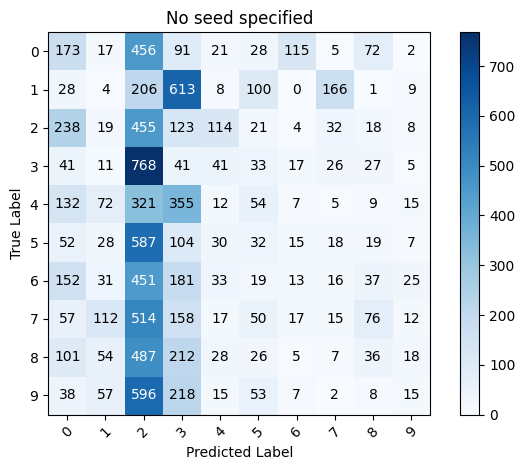

In [18]:
eval_ovo_classifier(no_seed_preds, test_y, 'No seed specified')

In [19]:
relu_preds = ovo_classifier(relu_train_x, train_y, relu_test_x, test_y)

100%|███████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:37<00:00,  3.49s/it]


Accuracy: 96.62%
Error rate: 3.38%


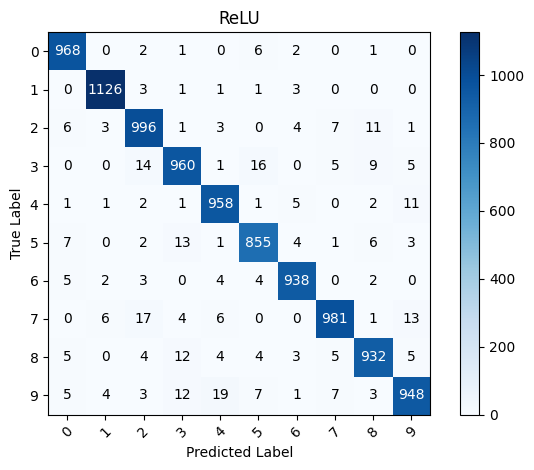

In [20]:
eval_ovo_classifier(relu_preds, test_y, 'ReLU')

In [21]:
sig_preds = ovo_classifier(sig_train_x, train_y, sig_test_x, test_y)

100%|███████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:28<00:00,  3.29s/it]


Accuracy: 94.89%
Error rate: 5.11%


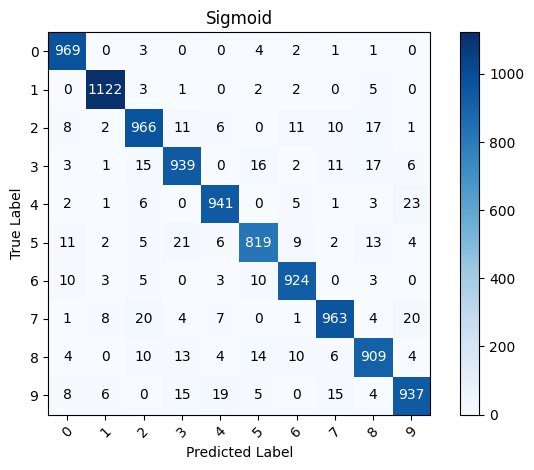

In [22]:
eval_ovo_classifier(sig_preds, test_y, 'Sigmoid')

In [23]:
sin_preds = ovo_classifier(sin_train_x, train_y, sin_test_x, test_y)

100%|███████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:32<00:00,  3.38s/it]


Accuracy: 10.16%
Error rate: 89.84%


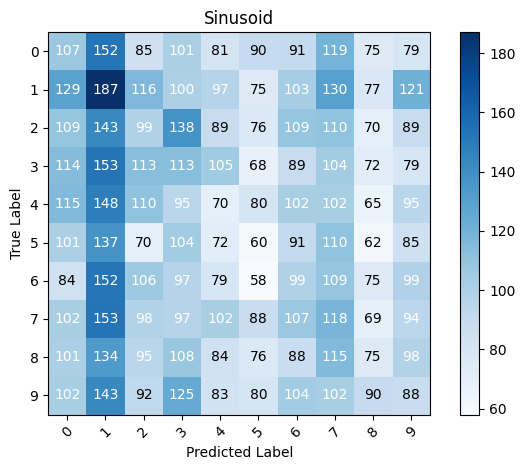

In [24]:
eval_ovo_classifier(sin_preds, test_y, 'Sinusoid')

In [29]:
def eval_features(preds, test_y):
    count = 0
    for i in range(len(test_y[0])):
        if test_y[0][i] == preds[i]:
            count += 1

    return 100 - (100 * count / len(test_y[0]))

In [30]:
eval_features(sin_preds, test_y)

89.84